<div style="text-align: center;">
    <span style="color: red; font-size: 70px;"> Ghiacciaio del Morteratsch </span>
</div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import itertools

from scipy.stats import linregress
from scipy.optimize import curve_fit

In [3]:
ASWdata = pd.read_excel('Boval#.xlsx')

data = ASWdata['Data'].to_numpy()
ora = ASWdata['Ora'].to_numpy()
windDir = ASWdata['WindDir'].to_numpy()
windSpeed = ASWdata['WindSpeed'].to_numpy()
maxSpeed = ASWdata['MaxSpeed'].to_numpy()
swin = ASWdata['Swin'].to_numpy()
swout = ASWdata['Swout'].to_numpy()
lwin = ASWdata['Lwin'].to_numpy()
lwout = ASWdata['Lwout'].to_numpy()
airT = ASWdata['AirT'].to_numpy()
relHum = ASWdata['RelHum'].to_numpy()
press = ASWdata['Press'].to_numpy()
alt = ASWdata['H'].to_numpy()
fusMeas = ASWdata['Fusion'].to_numpy()

mask = swin < 15
swin[mask] = 0
swout[mask] = 0

mask = swin < swout
swin[mask] = 1.1 * swout[mask]

<center>

## Temperatura superficiale

</center>

In [9]:
sigma = 5.67e-8; tempSup = pow(lwout/sigma, 1/4)
mask = tempSup > 273.15; tempSup[mask] = 273.15

tSupDaily = []; tsupday = 0
giorniReg = [data[0].split()[0]]; appo = data[0].split()[0]; conta = 0; 

for i in range(0, len(data)):

    if data[i].split()[0] == appo:
        conta += 1
        tsupday += tempSup[i]

    else:
        tSupDaily.append(tsupday/conta)
        giorniReg.append(data[i].split()[0])

        conta = 1
        appo = data[i].split()[0]
        tsupday = tempSup[i]

tSupDaily.append(tsupday/conta)

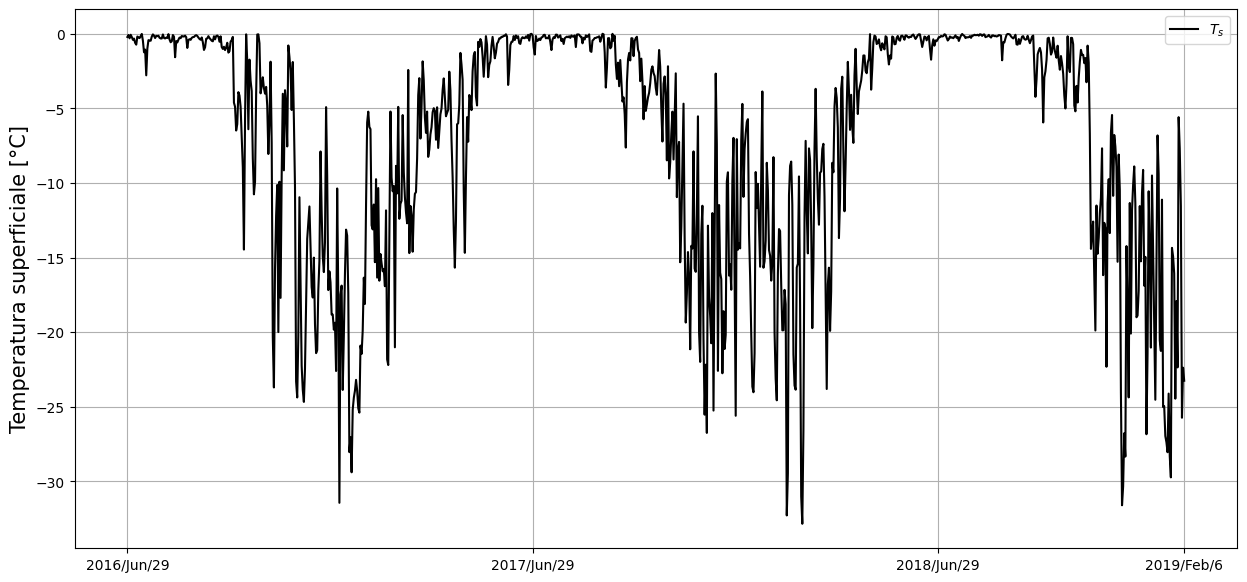

In [10]:
fig = plt.figure(figsize = (15,7))
 
plt.plot(giorniReg, np.array(tSupDaily) - 273.15, 'black', label = r'$T_s$')
plt.xticks([giorniReg[0], giorniReg[365], giorniReg[730], giorniReg[952]])

plt.ylabel(r'Temperatura superficiale [°C]', fontsize = 15)
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

<center>

## Fusione

</center>

In [12]:
# Radiazione netta
lwnet = lwin - lwout
swnet = swin - swout


# Sensible Heat Flux
alt[17547] = -2.91; alt[41198] = -1.73
wind2m = pow((2/abs(alt)), 0.148) * windSpeed
sigma = 5.67e-8 * 0.97; tempSup = pow(lwout/sigma, 0.25) - 273.15
mask = tempSup > 0; tempSup[mask] = 0
temp2m = []

for i in range(0, len(airT)):
    if airT[i] < 0:
        temp2m.append(airT[i])
    elif airT[i] == 0:
        temp2m.append((airT[i]) * pow(2/abs(alt[i]), 0.162))
    else:
        temp2m.append((airT[i]) * pow(2/abs(alt[i]), 0.126))

temp2m = np.array(temp2m)
pa = 1000; cp = 1.006; ch = 0.00127
sensibleHeat = pa * cp * ch * wind2m * (temp2m - tempSup)


# Latent Heat Flux
es = 6.112 * np.exp(17.67 * tempSup/(tempSup + 243.5))
es2m = 6.112 * np.exp(17.67 * temp2m/(temp2m + 243.5))

ws2m = 0.622 * es2m/(press - es2m)
w2m = relHum/100 * ws2m

lv = 2.501 - 2.361e-3 * airT
e2m = press * (w2m/(w2m + 0.622))

latentHeat = 0.622 * lv * ch * wind2m * (e2m - es) * 1e6/press

In [13]:
mask = swin > 15
swin_al = swin[mask]; swout_al = swout[mask]
data_al = data[mask]; albedo = swout_al/swin_al

albedoDaily = []; albedoday = 0
giorniReg = [str(data_al[0]).split()[0]]; appo = str(data_al[0]).split()[0]; conta = 0; 

for i in range(0, len(data_al)):

    if str(data_al[i]).split()[0] == appo:
        conta += 1
        albedoday += albedo[i]

    else:
        giorniReg.append(str(data_al[i]).split()[0])
        albedoDaily.append(albedoday/conta)

        conta = 1
        appo = str(data_al[i]).split()[0]
        albedoday = albedo[i]


albedoDaily.append(albedoday/conta)

In [14]:
# Total energy budget
latGh = 334000; sommaComp = swnet + lwnet + sensibleHeat + latentHeat
sommaComp = sommaComp * 3600; giorniReg = []


# Giorni survey
giorniReg = [str(data[0]).split()[0]]; appo = str(data[0]).split()[0]; 
for i in range(0, len(data)):

    if str(data[i]).split()[0] != appo:
        giorniReg.append(str(data[i]).split()[0])
        appo = str(data[i]).split()[0]


# Fusione singole fascie orarie
fusione = []; giorniReg = np.array(giorniReg); conta = 0
for i in range(0, len(sommaComp) - 1):
    if str(data[i]).split()[0] == str(data[i+1]).split()[0]:
        if sommaComp[i] > 0 and tempSup[i] == 0 and albedoDaily[conta] < 0.35:
            fusione.append(-sommaComp[i]/latGh) 
        else:
            fusione.append(0)
    
    else:
        conta += 1

        if sommaComp[i] > 0 and tempSup[i] == 0 and albedoDaily[conta] < 0.35:
            fusione.append(-sommaComp[i]/latGh) 
        else:
            fusione.append(0)

fusione.append(0)
fusione = np.array(fusione)


# Fusione cumulativa
fDaily = []; fday = 0; appo = giorniReg[0]

for i in range(0, len(data)):

    if str(data[i]).split()[0] == appo:
        fday += fusione[i]

    else:
        fDaily.append(fday)
        appo = str(data[i]).split()[0]
        fday = fusione[i]

fDaily.append(fday)

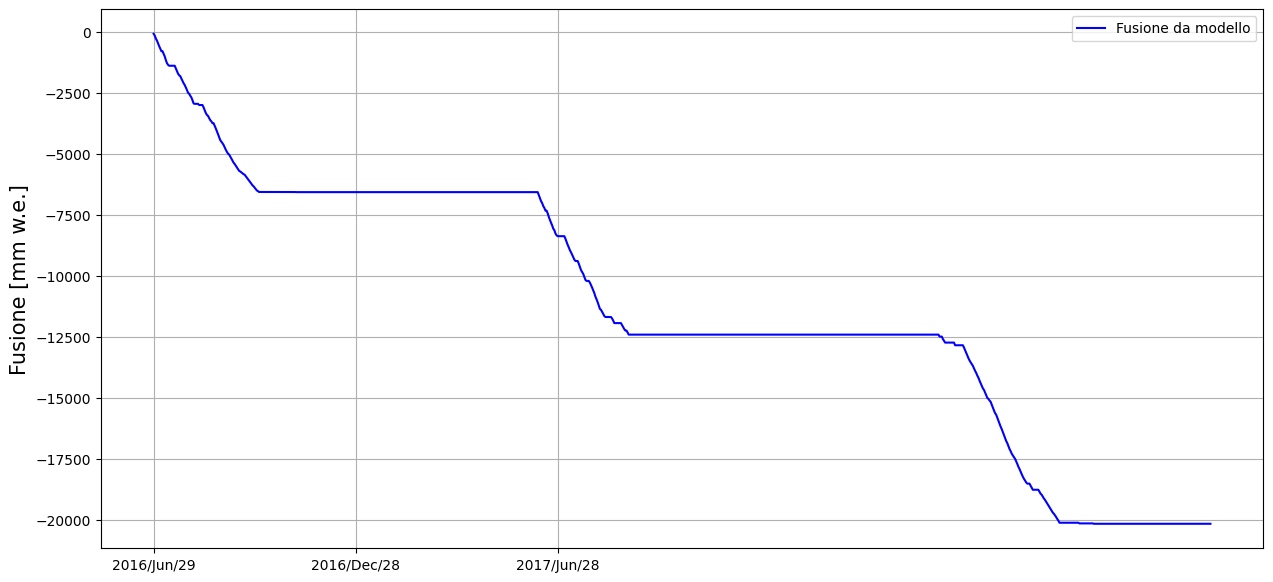

In [15]:
fig = plt.figure(figsize = (15,7))
 
plt.plot(giorniReg, np.array(np.cumsum(fDaily)), 'blue', label = r'Fusione da modello')
plt.xticks([giorniReg[0], giorniReg[182], giorniReg[364]])

plt.ylabel('Fusione [mm w.e.]', fontsize = 15)
plt.legend(loc = 'best')
plt.grid(True)
plt.show()